In [38]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [39]:
# Load and prepare data
df = pd.read_csv(r'/content/bren.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)




In [40]:
df.head()

,Unnamed: 0,Date,Price,LogReturn
0,1,1987-05-21,18.45,-0.009709
1,2,1987-05-22,18.55,0.005405
2,3,1987-05-25,18.60,0.002692
3,4,1987-05-26,18.63,0.001612
4,5,1987-05-27,18.60,-0.001612


In [41]:
# Proper resampling with Date preserved
monthly_df = df.resample('M', on='Date').last().copy()
monthly_df['LogReturn'] = np.log(monthly_df['Price'] / monthly_df['Price'].shift(1))
monthly_df.dropna(inplace=True)

# Ensure 'Date' becomes a column again
monthly_df.reset_index(inplace=True)



/tmp/ipython-input-3699360214.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M', on='Date').last().copy()


In [42]:
monthly_df.head()

,Date,Unnamed: 0,Price,LogReturn
0,1987-06-30,28,19.08,0.026555
1,1987-07-31,51,20.03,0.048590
2,1987-08-31,72,18.63,-0.072458
3,1987-09-30,94,18.48,-0.008084
4,1987-10-31,116,18.80,0.017168


In [43]:
# 🎯 Step 4: Prepare log return data for modeling
returns = monthly_df['LogReturn'].values
n = len(returns)
print(f"Number of monthly data points: {n}")

Number of monthly data points: 426


In [44]:
returns_std = (returns - np.mean(returns)) / np.std(returns)

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns_std)

    trace = pm.sample(
        4000, tune=2000,
        chains=4, cores=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=42
    )

Output()

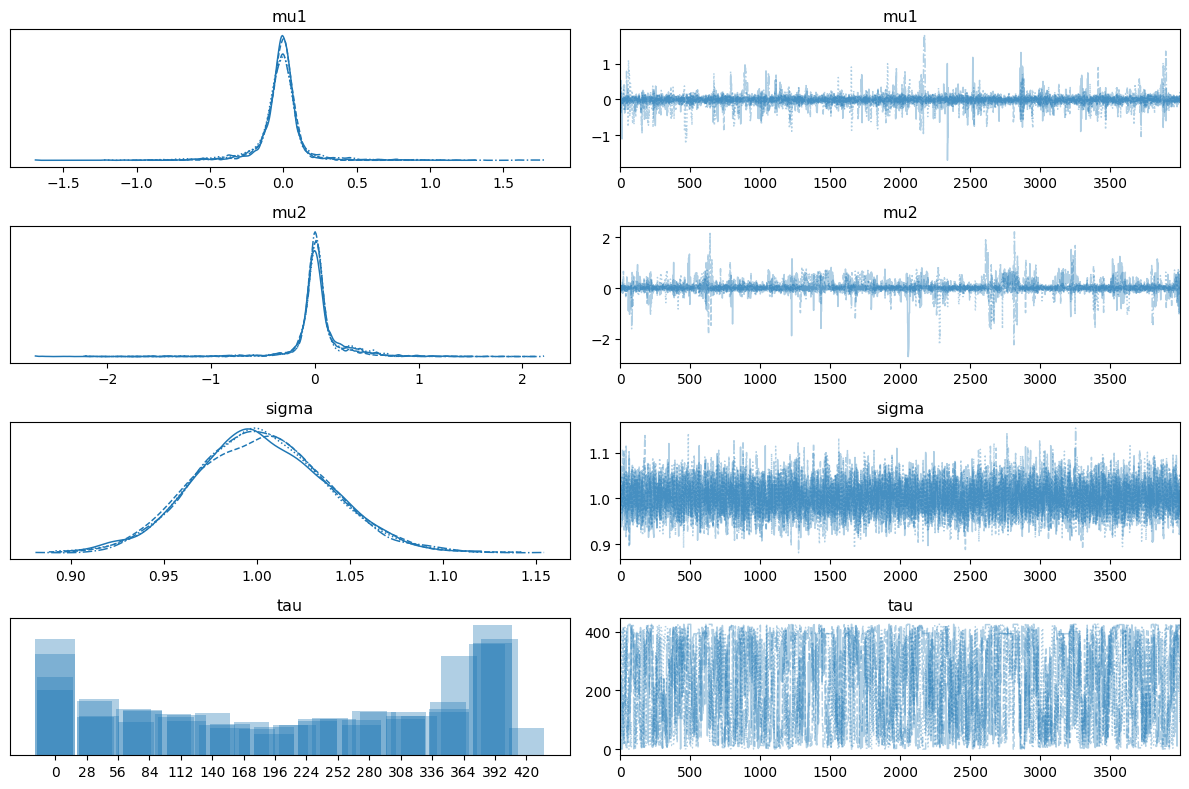

          mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu1     -0.018    0.156    -0.343      0.265      0.003    0.010    4032.0   
mu2      0.029    0.238    -0.301      0.616      0.007    0.016    1144.0   
sigma    1.002    0.035     0.938      1.073      0.000    0.000    6507.0   
tau    227.050  147.932     8.000    425.000      6.387    1.364     552.0   

       ess_tail  r_hat  
mu1      2060.0   1.00  
mu2       831.0   1.01  
sigma    6820.0   1.00  
tau       853.0   1.01  


In [45]:
# Trace plots to check convergence
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Summary statistics
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

In [46]:
print(monthly_df.head())



        Date  Unnamed: 0  Price  LogReturn
0 1987-06-30          28  19.08   0.026555
1 1987-07-31          51  20.03   0.048590
2 1987-08-31          72  18.63  -0.072458
3 1987-09-30          94  18.48  -0.008084
4 1987-10-31         116  18.80   0.017168


Detected change point at index 244, which corresponds to 2007-10-31 00:00:00


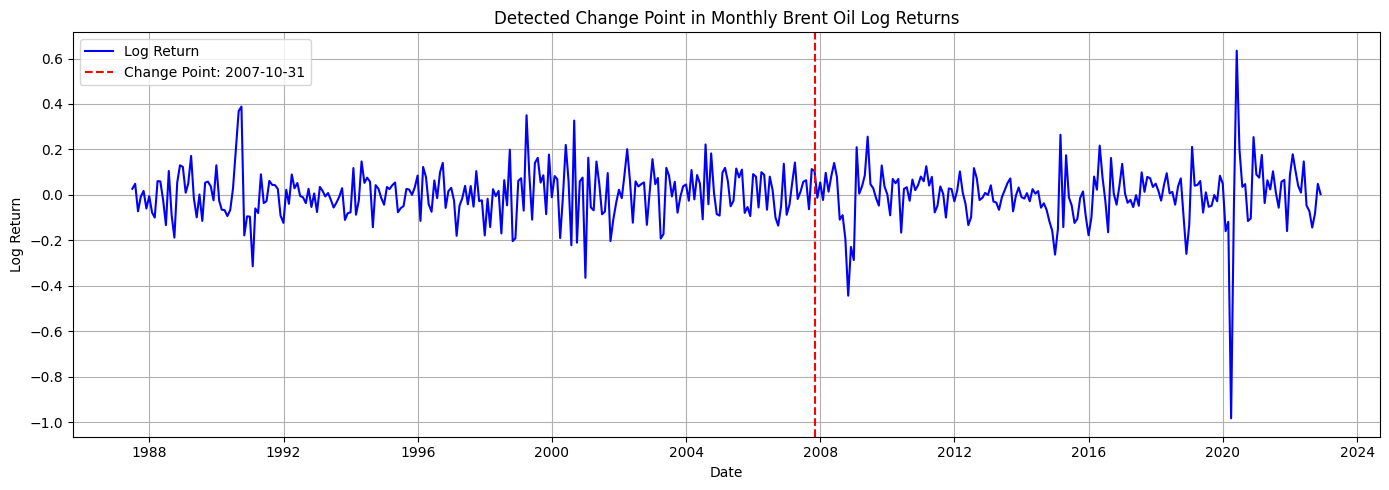

In [47]:
# Step 7: Extract most likely change point index and visualize

# Get tau samples from the posterior and compute the most likely index
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.median(tau_samples))

# Get the date corresponding to the change point index
change_date = monthly_df.loc[most_likely_tau, 'Date']

print(f"Detected change point at index {most_likely_tau}, which corresponds to {change_date}")

# Plot the log returns with the detected change point
plt.figure(figsize=(14, 5))
plt.plot(monthly_df['Date'], monthly_df['LogReturn'], label='Log Return', color='blue')
plt.axvline(change_date, color='red', linestyle='--', label=f'Change Point: {change_date.date()}')
plt.title('Detected Change Point in Monthly Brent Oil Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

